# 1.2.0 Heatmap Papers
Want to prioritize words that are genes

In [1]:
import pandas as pd
import requests
from glob import glob
import json
from copy import deepcopy

In [2]:
from clustergrammer2 import net

In [3]:
all_files = glob('../markdown_files/*.md')
len(all_files)

118

### Load Altmetric Data

In [4]:
dict_altmetric = net.load_json_to_dict('../altmetric_data/altmetric_scores.json')

### Load Google Sheet Data

In [5]:
google_sheet_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRngfhDKqZUEhHuQY60n3Bh76gkMQKeOq6D7UYkSgt0KPP7rcCTE-PjMeWO1g1YlGVhBTAMJS6rn-pc/pub?gid=0&single=true&output=tsv'

In [6]:
r = requests.get(google_sheet_url)
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
TESTDATA = StringIO(r.text)
df = pd.read_csv(TESTDATA, sep="\t", index_col=0)
df.index.name = None

### Download Latest Preprints

In [7]:
url = 'https://connect.biorxiv.org/relate/collection_json.php?grp=181'

In [8]:
r = requests.get(url)

In [9]:
req_dict = json.loads(r.text)

In [10]:
stop_words = ["i","me","my","myself","we","us","our","ours","ourselves","you","your","yours","yourself","yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself","they","them","their","theirs","themselves","what","which","who","whom","whose","this","that","these","those","am","is","are","was","were","be","been","being","have","has","had","having","do","does","did","doing","will","would","should","can","could","ought","i'm","you're","he's","she's","it's","we're","they're","i've","you've","we've","they've","i'd","you'd","he'd","she'd","we'd","they'd","i'll","you'll","he'll","she'll","we'll","they'll","isn't","aren't","wasn't","weren't","hasn't","haven't","hadn't","doesn't","don't","didn't","won't","wouldn't","shan't","shouldn't","can't","cannot","couldn't","mustn't","let's","that's","who's","what's","here's","there's","when's","where's","why's","how's","a","an","the","and","but","if","or","because","as","until","while","of","at","by","for","with","about","against","between","into","through","during","before","after","above","below","to","from","up","upon","down","in","out","on","off","over","under","again","further","then","once","here","there","when","where","why","how","all","any","both","each","few","more","most","other","some","such","no","nor","not","only","own","same","so","than","too","very","say","says","said","shall","2019","novel","patients","using","may","2019-ncov","2020"]
stop_words.extend(['2020,', 'conclusions', 'characteristics'])
stop_words.extend(['=', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [11]:
more_stop_words = ['data', 'results', 'study', 'used', 'also', 'analysis', 'two', 'one', 'different', 'however',
                  'early', 'first', 'found', 'new', 'well', 'show', 'three', 'use', 'important', 'method', 'observed', 
                  'studies', 'across', 'due', 'likely', 'included', 'suggest', 'many', 'similar', 'around', 
                  'several', 'still', 'even', 'basic', 'four', 'much', 'now', 'five', 'six', 'since', 'thus', 
                  'especially', 'end', 'considered', 'result', 'find', 'general', 'best', 'thus']
stop_words.extend(more_stop_words)

In [12]:
doi_words = {}
all_words = []
doi_titles = {}
doi_site = {}
arr_papers = req_dict['rels']
for inst_paper in arr_papers:

    # get words from abstract
    inst_words = [x.lower().replace(':','').replace(',','').replace('.','')
                           .replace('(', '').replace(')', '')
                           .replace('\n','').replace('\t','')
                           for x in inst_paper['rel_abs'].split()]
    
    # explicit drop words
    inst_words = [x for x in inst_words if x not in stop_words]    
    
    # drop words that do not contain letters
    inst_words = [x for x in inst_words if x.islower()]
    
    # save words to dict 
    doi_words[inst_paper['rel_doi']] = sorted(list(set(inst_words)))
    
    doi_titles[inst_paper['rel_doi']] = inst_paper['rel_title']
    
    doi_site[inst_paper['rel_doi']] = inst_paper['rel_site']
    
    all_words.extend(inst_words)

In [13]:
ser_titles = pd.Series(doi_titles)
ser_titles.head()

10.1101/2020.04.11.20062190    Estimating the real-time case fatality rate of...
10.1101/2020.04.11.20062133    Intervention strategies against COVID-19 and t...
10.1101/2020.04.11.20062042    Human agency and infection rates: implications...
10.1101/2020.04.11.20056010    Household Secondary Attack Rate of COVID-19 an...
10.1101/2020.04.10.20061267    Public perceptions and experiences of social d...
dtype: object

In [14]:
df_meta = pd.DataFrame(ser_titles, columns=['Title'])
df_meta.shape

(1687, 1)

### Add Paper Metadata

In [15]:
inst_paper.keys()

dict_keys(['rel_title', 'rel_doi', 'rel_link', 'rel_abs', 'rel_authors', 'rel_date', 'rel_site'])

In [16]:
for inst_paper in arr_papers:
    inst_doi = inst_paper['rel_doi']
    
    # date
    inst_date = inst_paper['rel_date'].split('-')
    df_meta.loc[inst_doi, 'date'] = float( inst_date[1] + '.' + inst_date[2])
    
    # altmetric score
    if inst_doi in dict_altmetric:
        df_meta.loc[inst_doi, 'altmetric'] = dict_altmetric[inst_doi]
    else:
        print('not found')
        df_meta.loc[inst_doi, 'altmetric'] = 0

not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


In [17]:
ser_count = pd.Series(all_words).value_counts()
ser_count = ser_count[ser_count < len(arr_papers) * 0.75 ][ser_count > 5]
ser_count.shape

(4142,)

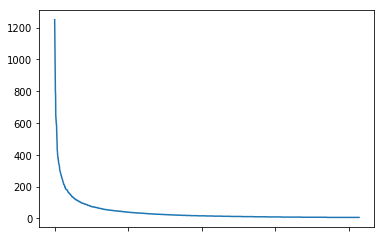

In [18]:
ser_count.plot()

In [19]:
top_words = ser_count.index.tolist()[:1000]

In [20]:
all_dois = sorted(list(doi_words.keys()))
len(all_dois)

1687

In [21]:
df_words = pd.DataFrame(0, index=top_words, columns=all_dois)

In [22]:
for inst_doi in all_dois:
    inst_words = list(set(doi_words[inst_doi]).intersection(top_words))
    df_words.loc[inst_words, inst_doi] = 1

### Add Column Categories

In [23]:
cols = df_words.columns.tolist()

In [36]:
grade_dict = {}
for inst_col in cols:
    if inst_col in df.index.tolist():
        grade_dict[inst_col] = str(df.loc[inst_col, 'Grade'])\
                                 .replace('2-3', '3')\
                                 .replace('2-1', '2')\
                                 .replace('1-2', '2')\
                                 .replace('1/2', '2')\
                                 .replace('nan', 'N.A.').replace('?','')
    else:
        grade_dict[inst_col] = 'N.A.'

In [37]:

new_cols = [(df_meta.loc[x, 'Title'][:50], 
             'Site: ' + doi_site[x],
             'Grade: ' + str(grade_dict[x]),
             'Date: ' + str(df_meta.loc[x, 'date']), 
             'Altmetric: ' + str(df_meta.loc[x, 'altmetric']) )  for x in cols]
df_cat = deepcopy(df_words)
df_cat.columns = new_cols

In [38]:
cat_colors = {}
cat_colors['biorxiv'] = 'blue'
cat_colors['red'] = 'red'
cat_colors['N.A.'] = 'white'
cat_colors['nan'] = 'white'
cat_colors['1'] = '#FFD700'
cat_colors['2'] = '#FF6347'
cat_colors['3'] = '#add8e6'

In [39]:
net.load_df(df_cat)
net.set_cat_colors(axis='col', cat_index=1, cat_title='Site', cat_colors=cat_colors)
net.set_cat_colors(axis='col', cat_index=2, cat_title='Grade', cat_colors=cat_colors)
net.filter_N_top(inst_rc='row', rank_type='sum', N_top=500)
net.cluster(dist_type='jaccard')
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "coronavirus", "ini": 500, "clust": 404, "rank": 499, "rankvar"…

In [28]:
net.save_dict_to_json(net.viz, '../json_files/heatmap_2020-04-05.json')

### Words and Reviews

In [29]:
# words_list = []
# for inst_file in all_files:
#     f = open(inst_file, 'r')
#     lines = f.readlines()
#     f.close()
    
#     for inst_line in lines:
#         inst_line = inst_line.lower()
            
#         inst_words = inst_line.split(' ')
#         inst_words = [x for x in inst_words if '*' not in x]
#         words_list.extend(inst_words)

In [30]:
# pd.Series(words_list).value_counts().head(50)